In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy.stats import mannwhitneyu

In [2]:
path = "/Users/federicopigozzi/PycharmProjects/SoftBodies/output/"

In [44]:
data = read_files(path)

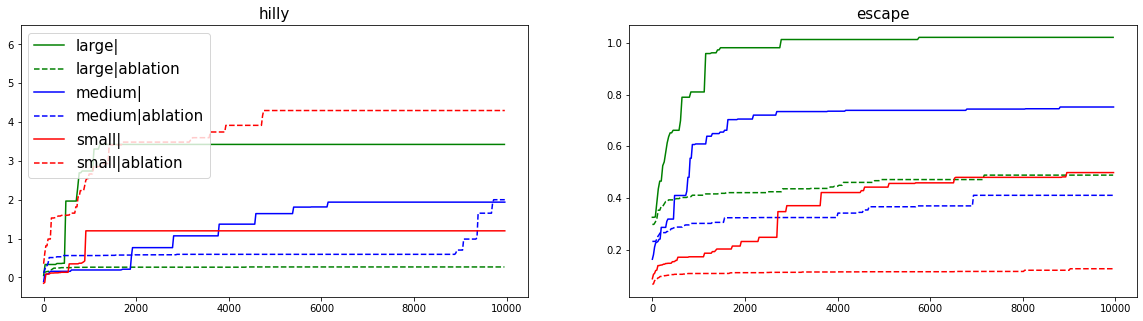

In [45]:
plot(data)

In [34]:
data = read_files(path, inflate=True)

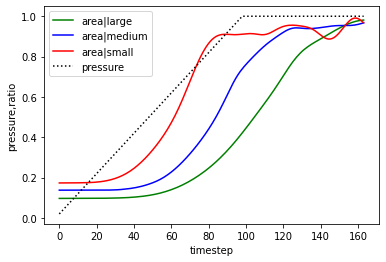

In [30]:
plot_inflation(data)

In [11]:
for (task, size), d in data.groupby(["task", "size"]):
    print("|".join([task, size, str(mannwhitneyu(d[d["ablation"] == True]["best.fitness"],
                                                 d[d["ablation"] == False]["best.fitness"],
                                                 alternative="two-sided")[1])]))

escape|large|9.169365553551005e-255
escape|medium|0.0
escape|small|0.0
hilly|large|0.0
hilly|medium|2.0958787812734596e-15
hilly|small|2.7418120384431423e-269


In [40]:
def read_files(path, inflate=False):
    data = None
    for root, dirs, files in os.walk(path):
        for file in files:
            if "npy" in file or file == ".DS_Store" or ("logs" in root and "ablation" not in root) or (inflate and "flat" not in file):
                continue
            d = pd.read_csv(os.path.join(root, file), sep=";")
            d["solver"] = file.split(".")[0]
            d["run"] = int(file.split(".")[1])
            d["task"] = file.split(".")[2]
            d["ablation"] = "ablation" in root
            d["size"] = root.split("/")[len(root.split("/")) - (3 if "ablation" in root else 1)]
            if data is None:
                data = pd.DataFrame(columns=d.columns)
            data = data.append(d)
    if not inflate:
        data["iteration"] = data["iteration"].astype(np.int32)
        data["evaluations"] = data["evaluations"].astype(np.int32)
    return data

In [4]:
def plot(data):
    fig, axes = plt.subplots(figsize=(20, 5), nrows=1, ncols=2)
    colors = {"small": "red", "medium": "blue", "large": "green"}
    for (task, size, ablation), d in data.groupby(["task", "size", "ablation"]):
        if task == "escape":
            d["best.fitness"] /= 30
        col = 0 if task == "hilly" else 1
        median = d["best.fitness"].groupby(d.iteration).median()
        err = d["best.fitness"].groupby(d.iteration).std()
        x = d["evaluations"].groupby(d.iteration).median()
        axes[col].plot(x, median, color=colors[size], linestyle="solid" if not ablation else "dashed", 
                       label="|".join([size, "ablation" if ablation else ""]))
        axes[col].set_title(task, fontsize=15)
    axes[0].set_ylim(-0.5, 6.5)
    axes[0].legend(fontsize=15)

In [26]:
def plot_inflation(data):
    colors = {"small": "red", "medium": "blue", "large": "green"}
    for size, d in data[data["t"] < 525].groupby(["size"]):
        plt.plot(d["r"], color=colors[size], label="|".join(["area", size]))
        if size == "small":
            plt.plot(d["p"] / d["p"].max(), linestyle="dotted", color="black", label="pressure")
    plt.xlabel("timestep")
    plt.ylabel("pressure,ratio")
    plt.legend()

In [47]:
for (task, ablation), t in data.groupby(["task", "ablation"]):
    if task != "escape":
        continue
    d = pd.DataFrame()
    for label, traj in t.groupby(["size"]):
        traj["best.fitness"] /= 30
        step = int(len(traj["iteration"].unique()) / 10 + 1)
        traj = traj[traj["iteration"] % step == 0]
        median = list(traj.groupby(traj.iteration)["best.fitness"].median())
        std = list(traj.groupby(traj.iteration)["best.fitness"].std())
        if len(median) < 10:
            median = median.extend([median[-1] * (5 * 10 - len(median))])
            std = std.extend([std[-1] * (5 * 10 - len(std))])
        d[label + "_mu"] = median
        d[label + "_std"] = std
    d["i"] = np.arange(0, len(d) * step, step)
    name = ".".join(["evo", task, "ablation" if ablation else "", "txt"]).replace("..", ".")
    d.to_csv(name, sep="\t", index=False)

In [48]:
for task, t in data.groupby(["task"]):
    if task != "escape":
        continue
    d = pd.DataFrame()
    for (size, ablation), traj in t.groupby(["size", "ablation"]):
        traj["best.fitness"] /= 30
        x = []
        for _, df in traj.groupby(["run"]):
            x.append(df[df["iteration"] == df["iteration"].max()]["best.fitness"].item())
        if len(x) < 5:
            x.extend([np.median(x)] * (5 - len(x)))
        d[size + ("_ablation" if ablation else "")] = x
    name = ".".join(["box", task, "txt"])
    d.to_csv(name, sep="\t", index=False)

In [37]:
d = pd.DataFrame()
for label, traj in data[data["t"] < 525].groupby(["size"]):
    d[label] = traj["r"]
d["p"] = traj["p"] / traj["p"].max()
d["t"] = np.arange(0, len(d))
name = ".".join(["val", "txt"])
d.to_csv(name, sep="\t", index=False)